In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import numpy as np
import optuna

In [51]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
min_max_scaler = MinMaxScaler()
window_size = 5
horizon = 1

# Functions

In [91]:
#
def currentdata(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.reset_index(inplace=True)
    data['Date'] = data['Date'].dt.strftime('%d-%m-%Y')
    
    def str_to_datetime(s):
        split = s.split('-')
        day, month, year = int(split[0]), int(split[1]), int(split[2])
        return datetime.datetime(day=day, month=month, year=year)
    data['Date'] = data['Date'].apply(str_to_datetime)
    
    first_row = data.iloc[:1]
    rest_of_data = data.iloc[1:]
    rest_of_data = rest_of_data[rest_of_data['Volume'] != 0]

    data = pd.concat([first_row, rest_of_data])
    data = data[['Date', 'Close']]
    data.index = data.pop('Date')
    return data

#
def create_dataset(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[(i + window_size):(i + window_size + horizon)])
    return np.array(X), np.array(y)

#
def create_model(model_type, window_size, horizon, units):
    model = Sequential()
    
    # Add the recurrent layer
    if model_type == 'LSTM':
        model.add(LSTM(units, activation = 'relu', return_sequences=False, input_shape=(window_size,1)))
    elif model_type == 'GRU':
        model.add(GRU(units, activation = 'relu', return_sequences=False, input_shape=(window_size,1)))
    
    # Add the output layer
    model.add(Dense(horizon))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mae')
    
    return model

def create_windows_horizons(series, window_size, horizon_size):
    X, y = [], []
    for i in range(len(series) - window_size - horizon_size + 1):
        X.append(series[i:(i + window_size)])
        y.append(series[i + window_size:i + window_size + horizon_size])
    return np.array(X), np.array(y).reshape(-1, horizon_size)

def create_model_lstm(trial):
    model = Sequential()
    
    # Defining the number of units in LSTM layers
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    
    # Defining dropout rate
    # dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5, step=0.1)
    
    model.add(LSTM(units=lstm_units, return_sequences=False, input_shape=(5, 1)))
    # model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=1))  # Output layer
    model.compile(loss="mae", optimizer="adam")

    return model

def create_model_gru(trial):
    model = Sequential()
    
    # Defining the number of units in LSTM layers
    gru_units = trial.suggest_categorical('gru_units', [32, 64, 128])

    model.add(GRU(units=gru_units, return_sequences=False, input_shape=(5, 1)))
    
    model.add(Dense(units=1))  # Output layer
    model.compile(loss="mae", optimizer="adam")

    return model

def objective_lstm(trial):
    close_prices = train_df['Close'].values

    X, y = create_windows_horizons(close_prices, 5, 1)
    
    # Define the cross-validation technique
    tscv = TimeSeriesSplit(n_splits=5)
    
    val_losses = []  # List to store validation losses for each fold
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = create_model_lstm(trial)
        early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
        history = model.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=200,
                            batch_size=trial.suggest_categorical('batch_size', [32, 64, 128]),
                            callbacks=[early_stopping],
                            verbose=0)
        
        val_losses.append(min(history.history['val_loss']))
    
    # Calculate average validation loss across all folds
    avg_val_loss = np.mean(val_losses)
    return avg_val_loss

def objective_gru(trial):
    close_prices = train_df['Close'].values

    X, y = create_windows_horizons(close_prices, 5, 1)
    
    # Define the cross-validation technique
    tscv = TimeSeriesSplit(n_splits=5)
    
    val_losses = []  # List to store validation losses for each fold
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = create_model_gru(trial)
        early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
        history = model.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=200,
                            batch_size=trial.suggest_categorical('batch_size', [32, 64, 128]),
                            callbacks=[early_stopping],
                            verbose=0)
        
        val_losses.append(min(history.history['val_loss']))
    
    # Calculate average validation loss across all folds
    avg_val_loss = np.mean(val_losses)
    return avg_val_loss

# Optuna Hyperparameter Tuning
def optimize_lstm():
    study = optuna.create_study(direction='minimize')
    study.optimize(objective_lstm, n_trials=30)
    best_params = study.best_params
    print("Best Hyperparameters:", best_params)
def optimize_gru():
    study = optuna.create_study(direction='minimize')
    study.optimize(objective_gru, n_trials=30)
    best_params = study.best_params
    print("Best Hyperparameters:", best_params)

# Data Preparation

In [96]:
# set date for train-test dataset
start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 5, 1)

In [118]:
data = yf.Ticker("BBCA.JK")
train_df = data.history(start=start_train, end=end_train)

# Buang data yang Volume = 0
# train_df = train_df[train_df['Volume'] != 0]

# train_df

In [101]:
test_df = data.history(start=start_test, end=end_test)
# test_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-01-02 00:00:00+07:00,9188.267221,9212.704102,9139.393459,9212.704102,30545200,0.0,0.0
2024-01-03 00:00:00+07:00,9212.704198,9212.704198,9114.956674,9139.393555,34603300,0.0,0.0
2024-01-04 00:00:00+07:00,9188.267480,9261.578125,9163.830599,9261.578125,56501800,0.0,0.0
2024-01-05 00:00:00+07:00,9286.014554,9383.762076,9261.577674,9359.325195,85290100,0.0,0.0
2024-01-08 00:00:00+07:00,9383.762076,9408.198956,9261.577674,9359.325195,50896000,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-24 00:00:00+07:00,9825.000000,9950.000000,9750.000000,9950.000000,132832700,0.0,0.0
2024-04-25 00:00:00+07:00,10000.000000,10000.000000,9700.000000,9775.000000,104874100,0.0,0.0
2024-04-26 00:00:00+07:00,9700.000000,9825.000000,9625.000000,9625.000000,100932900,0.0,0.0


In [ ]:
data = currentdata("BBCA.JK", start_train, end_train)

plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price IDR')
plt.show

# Cross Validation

In [92]:
data = currentdata("BBCA.JK", start_train, end_train)
data

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2019-01-01,5200.0
2019-01-02,5240.0
2019-01-03,5180.0
2019-01-04,5205.0
2019-01-07,5245.0
...,...
2023-12-21,9325.0
2023-12-22,9325.0
2023-12-27,9375.0


In [93]:
data = currentdata("BBCA.JK", start_train, end_train)
optimize_lstm()
optimize_gru()

# LSTM 128 32

[*********************100%%**********************]  1 of 1 completed
[I 2024-06-20 08:51:37,957] A new study created in memory with name: no-name-8f50ebe5-0583-4e4f-8714-0d1abc3594d1
[I 2024-06-20 08:53:35,076] Trial 0 finished with value: 3888.11552734375 and parameters: {'lstm_units': 128, 'batch_size': 64}. Best is trial 0 with value: 3888.11552734375.
[I 2024-06-20 08:55:29,711] Trial 1 finished with value: 3892.44189453125 and parameters: {'lstm_units': 128, 'batch_size': 64}. Best is trial 0 with value: 3888.11552734375.
[I 2024-06-20 08:56:44,642] Trial 2 finished with value: 3919.7828125 and parameters: {'lstm_units': 64, 'batch_size': 64}. Best is trial 0 with value: 3888.11552734375.
[I 2024-06-20 08:57:53,111] Trial 3 finished with value: 3937.04375 and parameters: {'lstm_units': 64, 'batch_size': 128}. Best is trial 0 with value: 3888.11552734375.
[I 2024-06-20 08:59:01,937] Trial 4 finished with value: 3933.3484375 and parameters: {'lstm_units': 32, 'batch_size': 64}. Best

Best Hyperparameters: {'lstm_units': 128, 'batch_size': 32}


[I 2024-06-20 09:46:07,815] Trial 0 finished with value: 3817.888232421875 and parameters: {'gru_units': 64, 'batch_size': 32}. Best is trial 0 with value: 3817.888232421875.
[I 2024-06-20 09:47:31,512] Trial 1 finished with value: 3886.8013671875 and parameters: {'gru_units': 128, 'batch_size': 128}. Best is trial 0 with value: 3817.888232421875.
[I 2024-06-20 09:49:36,668] Trial 2 finished with value: 3702.83388671875 and parameters: {'gru_units': 128, 'batch_size': 32}. Best is trial 2 with value: 3702.83388671875.
[I 2024-06-20 09:50:57,591] Trial 3 finished with value: 3825.673681640625 and parameters: {'gru_units': 64, 'batch_size': 32}. Best is trial 2 with value: 3702.83388671875.
[I 2024-06-20 09:51:56,606] Trial 4 finished with value: 3913.920361328125 and parameters: {'gru_units': 32, 'batch_size': 64}. Best is trial 2 with value: 3702.83388671875.
[I 2024-06-20 09:52:55,987] Trial 5 finished with value: 3916.06123046875 and parameters: {'gru_units': 64, 'batch_size': 128}. 

Best Hyperparameters: {'gru_units': 128, 'batch_size': 32}


In [94]:
data = currentdata("BBRI.JK", start_train, end_train)
optimize_lstm()
optimize_gru()

[*********************100%%**********************]  1 of 1 completed
[I 2024-06-20 10:34:00,715] A new study created in memory with name: no-name-2d298995-09ef-458d-8d31-72b797463416
[I 2024-06-20 10:35:27,204] Trial 0 finished with value: 3897.22529296875 and parameters: {'lstm_units': 64, 'batch_size': 32}. Best is trial 0 with value: 3897.22529296875.
[I 2024-06-20 10:37:29,811] Trial 1 finished with value: 3840.215625 and parameters: {'lstm_units': 128, 'batch_size': 32}. Best is trial 1 with value: 3840.215625.
[I 2024-06-20 10:38:44,429] Trial 2 finished with value: 3922.359033203125 and parameters: {'lstm_units': 64, 'batch_size': 64}. Best is trial 1 with value: 3840.215625.
[I 2024-06-20 10:39:34,914] Trial 3 finished with value: 3943.807177734375 and parameters: {'lstm_units': 32, 'batch_size': 128}. Best is trial 1 with value: 3840.215625.
[I 2024-06-20 10:40:53,377] Trial 4 finished with value: 3918.8677734375 and parameters: {'lstm_units': 32, 'batch_size': 32}. Best is tr

Best Hyperparameters: {'lstm_units': 128, 'batch_size': 32}


[I 2024-06-20 11:25:47,627] Trial 0 finished with value: 3919.66337890625 and parameters: {'gru_units': 32, 'batch_size': 64}. Best is trial 0 with value: 3919.66337890625.
[I 2024-06-20 11:27:08,422] Trial 1 finished with value: 3825.4994140625 and parameters: {'gru_units': 64, 'batch_size': 32}. Best is trial 1 with value: 3825.4994140625.
[I 2024-06-20 11:27:58,748] Trial 2 finished with value: 3933.068310546875 and parameters: {'gru_units': 32, 'batch_size': 128}. Best is trial 1 with value: 3825.4994140625.
[I 2024-06-20 11:29:18,484] Trial 3 finished with value: 3878.985400390625 and parameters: {'gru_units': 32, 'batch_size': 32}. Best is trial 1 with value: 3825.4994140625.
[I 2024-06-20 11:30:37,206] Trial 4 finished with value: 3822.29267578125 and parameters: {'gru_units': 64, 'batch_size': 32}. Best is trial 4 with value: 3822.29267578125.
[I 2024-06-20 11:31:40,264] Trial 5 finished with value: 3889.7935546875 and parameters: {'gru_units': 64, 'batch_size': 64}. Best is tr

Best Hyperparameters: {'gru_units': 128, 'batch_size': 32}


In [95]:
data = currentdata("BMRI.JK", start_train, end_train)
optimize_lstm()
optimize_gru()

[*********************100%%**********************]  1 of 1 completed
[I 2024-06-20 12:12:01,224] A new study created in memory with name: no-name-214aa4f9-aa0f-4da6-b691-7fefdc1c604c
[I 2024-06-20 12:12:51,133] Trial 0 finished with value: 3944.537451171875 and parameters: {'lstm_units': 32, 'batch_size': 128}. Best is trial 0 with value: 3944.537451171875.
[I 2024-06-20 12:13:41,519] Trial 1 finished with value: 3944.838427734375 and parameters: {'lstm_units': 32, 'batch_size': 128}. Best is trial 0 with value: 3944.537451171875.
[I 2024-06-20 12:14:41,255] Trial 2 finished with value: 3937.9712890625 and parameters: {'lstm_units': 64, 'batch_size': 128}. Best is trial 2 with value: 3937.9712890625.
[I 2024-06-20 12:15:53,329] Trial 3 finished with value: 3923.82744140625 and parameters: {'lstm_units': 64, 'batch_size': 64}. Best is trial 3 with value: 3923.82744140625.
[I 2024-06-20 12:17:51,223] Trial 4 finished with value: 3826.960498046875 and parameters: {'lstm_units': 128, 'batc

Best Hyperparameters: {'lstm_units': 128, 'batch_size': 32}


[I 2024-06-20 13:02:09,350] Trial 0 finished with value: 3918.24736328125 and parameters: {'gru_units': 64, 'batch_size': 128}. Best is trial 0 with value: 3918.24736328125.
[I 2024-06-20 13:03:08,328] Trial 1 finished with value: 3917.998974609375 and parameters: {'gru_units': 64, 'batch_size': 128}. Best is trial 1 with value: 3917.998974609375.
[I 2024-06-20 13:04:26,527] Trial 2 finished with value: 3884.107275390625 and parameters: {'gru_units': 128, 'batch_size': 128}. Best is trial 2 with value: 3884.107275390625.
[I 2024-06-20 13:05:41,976] Trial 3 finished with value: 3884.7119140625 and parameters: {'gru_units': 128, 'batch_size': 128}. Best is trial 2 with value: 3884.107275390625.
[I 2024-06-20 13:07:42,414] Trial 4 finished with value: 3692.602978515625 and parameters: {'gru_units': 128, 'batch_size': 32}. Best is trial 4 with value: 3692.602978515625.
[I 2024-06-20 13:08:41,296] Trial 5 finished with value: 3914.40322265625 and parameters: {'gru_units': 32, 'batch_size': 

Best Hyperparameters: {'gru_units': 128, 'batch_size': 32}


# Modeling

## BCA

### BCA Data Prep

In [96]:
# set date for train-test dataset
start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)
# end_test = datetime.datetime.now()


In [97]:
train_df = currentdata("BBCA.JK", start_train, end_train)

# Buang data yang Volume = 0
# train_df = train_df[train_df['Volume'] != 0]

# train_df

[*********************100%%**********************]  1 of 1 completed


In [98]:
test_df = currentdata("BBCA.JK", start_test, end_test)
# test_df

[*********************100%%**********************]  1 of 1 completed


### BCA LSTM

In [99]:
import os

best_model_mape = float('inf')
best_model_name = ""

close_train = train_df['Close'].values
close_test = test_df['Close'].values
date_train = train_df.index
date_test = test_df.index

# Konfigurasi window size dan horizon
configs = [
    # {'window_size': 5, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 20, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 60, 'horizon': horizon, 'units':128, 'batch_size':32}
]

results = []

for config in configs:
    window_size = config['window_size']
    horizon = config['horizon']
    units = config['units']
    batch_size = config['batch_size']

    # Siapkan dataset
    X_train, y_train = create_windows_horizons(close_train, window_size, horizon)
    X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

    # Buat dan latih model
    model = create_model('LSTM', window_size, horizon, units)
    early_stopping = EarlyStopping(monitor='loss', patience=150, restore_best_weights=True)
    lstmBCA = model.fit(
        X_train, y_train,
        # validation_data=(X_test, y_test),
        epochs=1000,
        batch_size = batch_size,
        callbacks=[early_stopping],
        verbose=0
        )
    
    # Prediksi pada data testing
    y_pred = model.predict(X_test)
    
    # Evaluasi model dengan MAE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    model_name = f"BBCA_LSTM_window_{config['window_size']}.h5"
    model.save(model_name)
    
    # Update best model tracking
    if mape < best_model_mape:
        best_model_mape = mape
        if best_model_name:
            # Delete previous best model
            os.remove(best_model_name)
        best_model_name = model_name
    else:
        # Delete the current model as it's not the best
        os.remove(model_name)

    results.append({
        'config': config,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred,
        'y_test': y_test,
        'X_test': X_test
    })

# Tampilkan hasil
for result in results:
    config = result['config']
    mae = result['mae']
    rmse = result['rmse']
    mape = result['mape']
    y_pred = result['y_pred']
    y_test = result['y_test']
    X_test = result['X_test']
    
    print(f"Config: {config} - MAE: {mae} - RMSE: {rmse} - MAPE: {mape}")
    
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 104.93553565014368 - RMSE: 137.7854701341109 - MAPE: 1.0833710416530713
# Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 219.26565212673611 - RMSE: 268.46148524707854 - MAPE: 2.278320880053114
# Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 151.58514404296875 - RMSE: 189.22219940021407 - MAPE: 1.582949519487644

### Plotting

In [ ]:
from keras.models import load_model

window_size = 5
horizon = 1
close_test = test_df['Close'].values
X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

# Load the model
model = load_model('BBCA_LSTM_window_5.h5')

# Make predictions
predictions = model.predict(X_test)

# Print the predictions
print(predictions.shape)
print(X_test.shape)

3/3 [==============================] - 0s 3ms/step
(87, 1)
(87, 5)


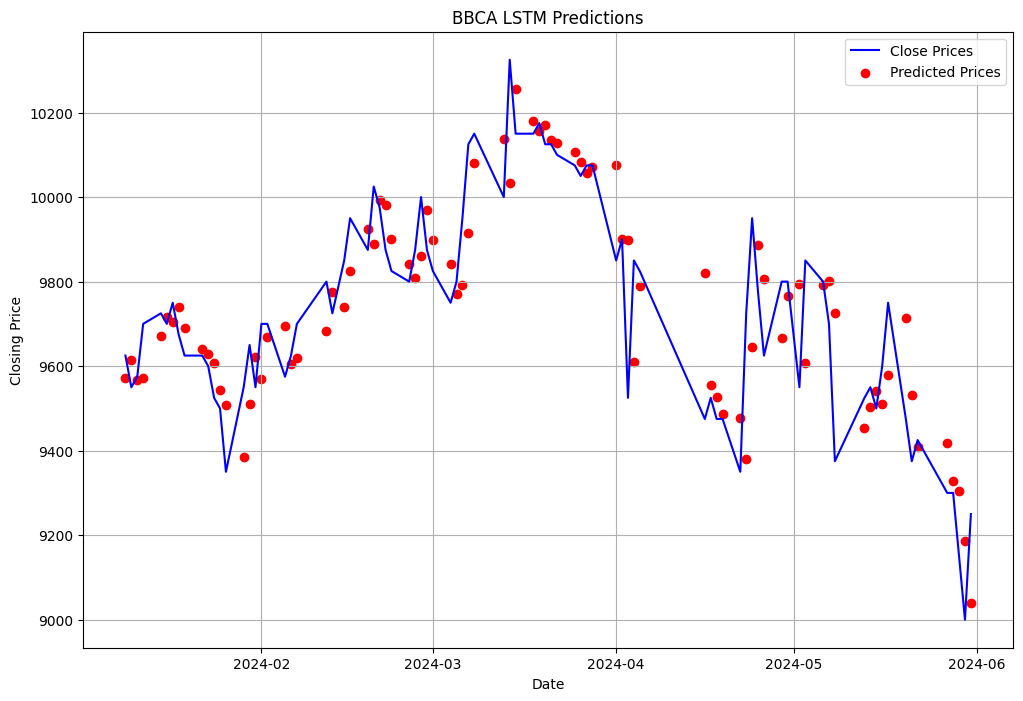

In [ ]:
# Assuming y_pred is a numpy array and test_df is your test DataFrame

# Step 0: Ensure test_df has the same number of rows as y_pred
# Calculate the difference in length
length_difference = len(test_df) - len(predictions)

# If test_df is longer, drop the excess rows from the end
if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

# Step 1: Convert y_pred to DataFrame
y_pred_df = pd.DataFrame(predictions, columns=['y_pred'])

# Step 2: Join y_pred DataFrame to test_df
# Assuming test_df has the same index as y_pred
test_df['y_pred'] = y_pred_df.values

# Filter test_df to only include rows where y_pred is not null
test_df = test_df.dropna(subset=['y_pred'])


# Step 3: Create the plot using data from the filtered test_df
plt.figure(figsize=(12, 8))

# Plot 'close' with a blue line
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')

# Plot 'y_pred' with a red line
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

# Add a legend
plt.legend()

# Optionally, add titles and labels
plt.title('BBCA LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')

plt.grid(True)

# Display the plot
plt.show()

### BCA GRU

In [ ]:
import os

best_model_mape = float('inf')
best_model_name = ""

close_train = train_df['Close'].values
close_test = test_df['Close'].values
date_train = train_df.index
date_test = test_df.index

# Konfigurasi window size dan horizon
configs = [
    # {'window_size': 5, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 20, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 60, 'horizon': horizon, 'units':128, 'batch_size':32}
]

results = []

for config in configs:
    window_size = config['window_size']
    horizon = config['horizon']
    units = config['units']
    batch_size = config['batch_size']

    # Siapkan dataset
    X_train, y_train = create_windows_horizons(close_train, window_size, horizon)
    X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

    # Buat dan latih model
    model = create_model('GRU', window_size, horizon, units)
    early_stopping = EarlyStopping(monitor='loss', patience=150, restore_best_weights=True)
    lstmBCA = model.fit(
        X_train, y_train,
        # validation_data=(X_test, y_test),
        epochs=1000,
        batch_size = batch_size,
        callbacks=[early_stopping],
        verbose=0
        )
    
    # Prediksi pada data testing
    y_pred = model.predict(X_test)
    
    # Evaluasi model dengan MAE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    model_name = f"BBCA_GRU_window_{config['window_size']}.h5"
    model.save(model_name)
    
    # Update best model tracking
    if mape < best_model_mape:
        best_model_mape = mape
        if best_model_name:
            # Delete previous best model
            os.remove(best_model_name)
        best_model_name = model_name
    else:
        # Delete the current model as it's not the best
        os.remove(model_name)

    results.append({
        'config': config,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred,
        'y_test': y_test,
        'X_test': X_test
    })

# Tampilkan hasil
for result in results:
    config = result['config']
    mae = result['mae']
    rmse = result['rmse']
    mape = result['mape']
    y_pred = result['y_pred']
    y_test = result['y_test']
    X_test = result['X_test']
    
    print(f"Config: {config} - MAE: {mae} - RMSE: {rmse} - MAPE: {mape}")
    
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 111.40372522865853 - RMSE: 147.31863438517325 - MAPE: 1.1466334885410787
# Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 117.34799148787313 - RMSE: 152.32485964815032 - MAPE: 1.2096833125777704
# Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 168.48556857638889 - RMSE: 196.47625371412508 - MAPE: 1.7733629177534755

1/1 [==============================] - 0s 202ms/step
Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 111.40372522865853 - RMSE: 147.31863438517325 - MAPE: 1.1466334885410787
Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 117.34799148787313 - RMSE: 152.32485964815032 - MAPE: 1.2096833125777704
Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 168.48556857638889 - RMSE: 196.47625371412508 - MAPE: 1.7733629177534755


## BRI

### BRI Data Prep

In [ ]:
# set date for train-test dataset
start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)

In [ ]:
train_df = currentdata("BBRI.JK", start_train, end_train)
# train_df

[*********************100%%**********************]  1 of 1 completed


In [ ]:
test_df = currentdata("BBRI.JK", start_test, end_test)
# test_df

[*********************100%%**********************]  1 of 1 completed


### BRI LSTM

In [ ]:
import os

best_model_mape = float('inf')
best_model_name = ""

close_train = train_df['Close'].values
close_test = test_df['Close'].values
date_train = train_df.index
date_test = test_df.index

# Konfigurasi window size dan horizon
configs = [
    # {'window_size': 5, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 20, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 60, 'horizon': horizon, 'units':128, 'batch_size':32}
]

results = []

for config in configs:
    window_size = config['window_size']
    horizon = config['horizon']
    units = config['units']
    batch_size = config['batch_size']

    # Siapkan dataset
    X_train, y_train = create_windows_horizons(close_train, window_size, horizon)
    X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

    # Buat dan latih model
    model = create_model('LSTM', window_size, horizon, units)
    early_stopping = EarlyStopping(monitor='loss', patience=150, restore_best_weights=True)
    lstmBCA = model.fit(
        X_train, y_train,
        # validation_data=(X_test, y_test),
        epochs=1000,
        batch_size = batch_size,
        callbacks=[early_stopping],
        verbose=0
        )
    
    # Prediksi pada data testing
    y_pred = model.predict(X_test)
    
    # Evaluasi model dengan MAE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    model_name = f"BBRI_LSTM_window_{config['window_size']}.h5"
    model.save(model_name)
    
    # Update best model tracking
    if mape < best_model_mape:
        best_model_mape = mape
        if best_model_name:
            # Delete previous best model
            os.remove(best_model_name)
        best_model_name = model_name
    else:
        # Delete the current model as it's not the best
        os.remove(model_name)

    results.append({
        'config': config,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred,
        'y_test': y_test,
        'X_test': X_test
    })

# Tampilkan hasil
for result in results:
    config = result['config']
    mae = result['mae']
    rmse = result['rmse']
    mape = result['mape']
    y_pred = result['y_pred']
    y_test = result['y_test']
    X_test = result['X_test']
    
    print(f"Config: {config} - MAE: {mae} - RMSE: {rmse} - MAPE: {mape}")
    
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 85.69625538793103 - RMSE: 111.16492137369004 - MAPE: 1.5619108902789571
# Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 87.86894395616319 - RMSE: 115.43951602765517 - MAPE: 1.606532859672419
# Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 1169.0650634765625 - RMSE: 1235.5270226936416 - MAPE: 24.398328743864866

1/1 [==============================] - 0s 119ms/step
Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 85.69625538793103 - RMSE: 111.16492137369004 - MAPE: 1.5619108902789571
Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 87.86894395616319 - RMSE: 115.43951602765517 - MAPE: 1.606532859672419
Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 1169.0650634765625 - RMSE: 1235.5270226936416 - MAPE: 24.398328743864866


### BRI GRU

In [ ]:
import os

best_model_mape = float('inf')
best_model_name = ""

close_train = train_df['Close'].values
close_test = test_df['Close'].values
date_train = train_df.index
date_test = test_df.index

# Konfigurasi window size dan horizon
configs = [
    # {'window_size': 5, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 20, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 60, 'horizon': horizon, 'units':128, 'batch_size':32}
]

results = []

for config in configs:
    window_size = config['window_size']
    horizon = config['horizon']
    units = config['units']
    batch_size = config['batch_size']

    # Siapkan dataset
    X_train, y_train = create_windows_horizons(close_train, window_size, horizon)
    X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

    # Buat dan latih model
    model = create_model('GRU', window_size, horizon, units)
    early_stopping = EarlyStopping(monitor='loss', patience=150, restore_best_weights=True)
    lstmBCA = model.fit(
        X_train, y_train,
        # validation_data=(X_test, y_test),
        epochs=1000,
        batch_size = batch_size,
        callbacks=[early_stopping],
        verbose=0
        )
    
    # Prediksi pada data testing
    y_pred = model.predict(X_test)
    
    # Evaluasi model dengan MAE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    model_name = f"BBRI_GRU_window_{config['window_size']}.h5"
    model.save(model_name)
    
    # Update best model tracking
    if mape < best_model_mape:
        best_model_mape = mape
        if best_model_name:
            # Delete previous best model
            os.remove(best_model_name)
        best_model_name = model_name
    else:
        # Delete the current model as it's not the best
        os.remove(model_name)

    results.append({
        'config': config,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred,
        'y_test': y_test,
        'X_test': X_test
    })

# Tampilkan hasil
for result in results:
    config = result['config']
    mae = result['mae']
    rmse = result['rmse']
    mape = result['mape']
    y_pred = result['y_pred']
    y_test = result['y_test']
    X_test = result['X_test']
    
    print(f"Config: {config} - MAE: {mae} - RMSE: {rmse} - MAPE: {mape}")
    
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 84.95304081357759 - RMSE: 111.01845885838149 - MAPE: 1.5521772148657298
# Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 89.33547634548611 - RMSE: 118.05646371149302 - MAPE: 1.641038682737663
# Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 84.17849731445312 - RMSE: 108.32391643870595 - MAPE: 1.6961340909398832

1/1 [==============================] - 0s 109ms/step
Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 84.95304081357759 - RMSE: 111.01845885838149 - MAPE: 1.5521772148657298
Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 89.33547634548611 - RMSE: 118.05646371149302 - MAPE: 1.641038682737663
Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 84.17849731445312 - RMSE: 108.32391643870595 - MAPE: 1.6961340909398832


## MRI

### MRI Data Prep

In [ ]:
# set date for train-test dataset
start_train = datetime.datetime(2019, 1, 1)
end_train = start_test = datetime.datetime(2024, 1, 1)
end_test = datetime.datetime(2024, 6, 1)

In [ ]:
train_df = currentdata("BMRI.JK", start_train, end_train)
# train_df

[*********************100%%**********************]  1 of 1 completed


In [ ]:
test_df = currentdata("BMRI.JK", start_test, end_test)
# test_df

[*********************100%%**********************]  1 of 1 completed


### MRI LSTM

In [ ]:
import os

best_model_mape = float('inf')
best_model_name = ""

close_train = train_df['Close'].values
close_test = test_df['Close'].values
date_train = train_df.index
date_test = test_df.index

# Konfigurasi window size dan horizon
configs = [
    # {'window_size': 5, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 20, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 60, 'horizon': horizon, 'units':128, 'batch_size':32}
]

results = []

for config in configs:
    window_size = config['window_size']
    horizon = config['horizon']
    units = config['units']
    batch_size = config['batch_size']

    # Siapkan dataset
    X_train, y_train = create_windows_horizons(close_train, window_size, horizon)
    X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

    # Buat dan latih model
    model = create_model('LSTM', window_size, horizon, units)
    early_stopping = EarlyStopping(monitor='loss', patience=150, restore_best_weights=True)
    lstmBCA = model.fit(
        X_train, y_train,
        # validation_data=(X_test, y_test),
        epochs=1000,
        batch_size = batch_size,
        callbacks=[early_stopping],
        verbose=0
        )
    
    # Prediksi pada data testing
    y_pred = model.predict(X_test)
    
    # Evaluasi model dengan MAE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    model_name = f"BMRI_LSTM_window_{config['window_size']}.h5"
    model.save(model_name)
    
    # Update best model tracking
    if mape < best_model_mape:
        best_model_mape = mape
        if best_model_name:
            # Delete previous best model
            os.remove(best_model_name)
        best_model_name = model_name
    else:
        # Delete the current model as it's not the best
        os.remove(model_name)

    results.append({
        'config': config,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred,
        'y_test': y_test,
        'X_test': X_test
    })

# Tampilkan hasil
for result in results:
    config = result['config']
    mae = result['mae']
    rmse = result['rmse']
    mape = result['mape']
    y_pred = result['y_pred']
    y_test = result['y_test']
    X_test = result['X_test']
    
    print(f"Config: {config} - MAE: {mae} - RMSE: {rmse} - MAPE: {mape}")
    
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 96.79248046875 - RMSE: 137.4379507301399 - MAPE: 1.4576959259444173
# Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 103.68859185112848 - RMSE: 145.31243533960222 - MAPE: 1.5548656925815176
# Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 767.1116790771484 - RMSE: 997.7730890063574 - MAPE: 12.507971566359483

1/1 [==============================] - 0s 153ms/step
Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 96.79248046875 - RMSE: 137.4379507301399 - MAPE: 1.4576959259444173
Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 103.68859185112848 - RMSE: 145.31243533960222 - MAPE: 1.5548656925815176
Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 767.1116790771484 - RMSE: 997.7730890063574 - MAPE: 12.507971566359483


### MRI GRU

In [ ]:
import os

best_model_mape = float('inf')
best_model_name = ""

close_train = train_df['Close'].values
close_test = test_df['Close'].values
date_train = train_df.index
date_test = test_df.index

# Konfigurasi window size dan horizon
configs = [
    # {'window_size': 5, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 20, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 60, 'horizon': horizon, 'units':128, 'batch_size':32}
]
results = []

for config in configs:
    window_size = config['window_size']
    horizon = config['horizon']
    units = config['units']
    batch_size = config['batch_size']

    # Siapkan dataset
    X_train, y_train = create_windows_horizons(close_train, window_size, horizon)
    X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

    # Buat dan latih model
    model = create_model('GRU', window_size, horizon, units)
    early_stopping = EarlyStopping(monitor='loss', patience=150, restore_best_weights=True)
    lstmBCA = model.fit(
        X_train, y_train,
        # validation_data=(X_test, y_test),
        epochs=1000,
        batch_size = batch_size,
        callbacks=[early_stopping],
        verbose=0
        )
    
    # Prediksi pada data testing
    y_pred = model.predict(X_test)
    
    # Evaluasi model dengan MAE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    model_name = f"BMRI_GRU_window_{config['window_size']}.h5"
    model.save(model_name)
    
    # Update best model tracking
    if mape < best_model_mape:
        best_model_mape = mape
        if best_model_name:
            # Delete previous best model
            os.remove(best_model_name)
        best_model_name = model_name
    else:
        # Delete the current model as it's not the best
        os.remove(model_name)

    results.append({
        'config': config,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred,
        'y_test': y_test,
        'X_test': X_test
    })

# Tampilkan hasil
for result in results:
    config = result['config']
    mae = result['mae']
    rmse = result['rmse']
    mape = result['mape']
    y_pred = result['y_pred']
    y_test = result['y_test']
    X_test = result['X_test']
    
    print(f"Config: {config} - MAE: {mae} - RMSE: {rmse} - MAPE: {mape}")
    
# Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 94.39104031968391 - RMSE: 134.3967541174342 - MAPE: 1.4176542721479464
# Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 105.96431477864583 - RMSE: 146.9249480225643 - MAPE: 1.590668290092153
# Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 125.73773193359375 - RMSE: 168.0408725830361 - MAPE: 1.9626465487212

1/1 [==============================] - 0s 139ms/step
Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 94.39104031968391 - RMSE: 134.3967541174342 - MAPE: 1.4176542721479464
Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 105.96431477864583 - RMSE: 146.9249480225643 - MAPE: 1.590668290092153
Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 125.73773193359375 - RMSE: 168.0408725830361 - MAPE: 1.9626465487212


In [ ]:
import numpy as np

# Get the last observed value from the training data
baseline_value = close_train[-1]

# Create an array of the same length as y_test with the baseline value
baseline_predictions = np.full_like(y_test, baseline_value)

# Calculate the MAE (Mean Absolute Error)
mae_baseline = np.mean(np.abs(baseline_predictions - y_test))

# Calculate the MAPE (Mean Absolute Percentage Error)
mape_baseline = np.mean(np.abs((baseline_predictions - y_test) / y_test)) * 100

# Print the baseline, MAE, and MAPE
print("Baseline Value:", baseline_value)
print("MAE (Baseline vs y_test):", mae_baseline)
print("MAPE (Baseline vs y_test):", mape_baseline)

# Create an array of the same length as y_test with the naive baseline value
naive_predictions = np.full_like(y_test, close_train[-1])

# Calculate the MAE (Mean Absolute Error) for the naive baseline
mae_naive = np.mean(np.abs(naive_predictions - y_test))

# Calculate the MAPE (Mean Absolute Percentage Error) for the naive baseline
mape_naive = np.mean(np.abs((naive_predictions - y_test) / y_test)) * 100

# Print the naive baseline, MAE, and MAPE
print("Naive Baseline Value:", close_train[-1])
print("MAE (Naive Baseline vs y_test):", mae_naive)
print("MAPE (Naive Baseline vs y_test):", mape_naive)

Baseline Value: 6050.0
MAE (Baseline vs y_test): 449.21875
MAPE (Baseline vs y_test): 6.745215962652629
Naive Baseline Value: 6050.0
MAE (Naive Baseline vs y_test): 449.21875
MAPE (Naive Baseline vs y_test): 6.745215962652629


[[6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]
 [6050.]]
(32, 1)


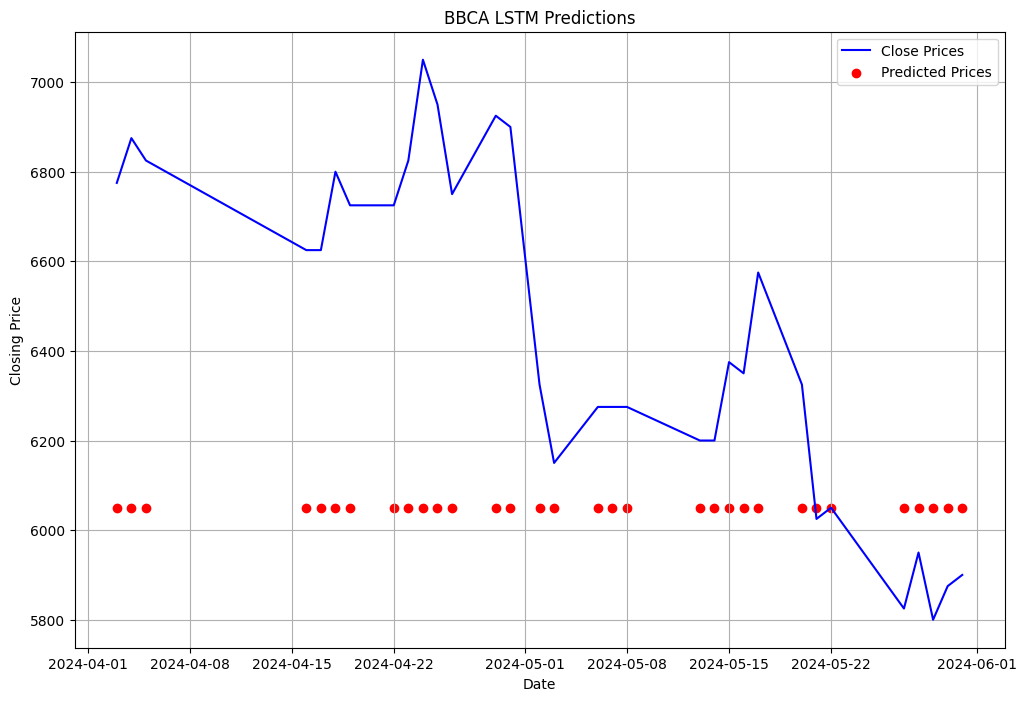

In [ ]:
print(naive_predictions)
print(naive_predictions.shape)

length_difference = len(test_df) - len(naive_predictions)

if length_difference > 0:
    test_df = test_df.iloc[length_difference:]

y_pred_df = pd.DataFrame(naive_predictions, columns=['y_pred'])

test_df['y_pred'] = y_pred_df.values

test_df = test_df.dropna(subset=['y_pred'])


plt.figure(figsize=(12, 8))

# Plot 'close' with a blue line
plt.plot(test_df['Close'], label='Close Prices', linestyle='-', color='blue')

# Plot 'y_pred' with a red line
plt.scatter(test_df.index, test_df['y_pred'], label='Predicted Prices', color='red')

# Add a legend
plt.legend()

# Optionally, add titles and labels
plt.title('BBCA LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')

plt.grid(True)

# Display the plot
plt.show()

# Coba-coba

### BCA LSTM

In [ ]:
# BCA LSTM
# data = currentdata("BBCA.JK", start_train, end_train)
import os

best_model_mape = float('inf')
best_model_name = ""

close_train = train_df['Close'].values
close_test = test_df['Close'].values
date_train = train_df.index
date_test = test_df.index

# Konfigurasi window size dan horizon
configs = [
    {'window_size': 5, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 20, 'horizon': horizon, 'units':128, 'batch_size':32},
    {'window_size': 60, 'horizon': horizon, 'units':128, 'batch_size':32}
]

results = []

for config in configs:
    window_size = config['window_size']
    horizon = config['horizon']
    units = config['units']
    batch_size = config['batch_size']

    # Siapkan dataset
    X_train, y_train = create_windows_horizons(close_train, window_size, horizon)
    X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

    # if X.shape[0] == 0:
    #     print(f"Dataset is too small for given window size and horizon")
    # else:
    #     X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # # Bagi dataset menjadi training dan testing
    # split = int(0.8 * len(X))
    # X_train, X_test = X[:split], X[split:]
    # y_train, y_test = y[:split], y[split:]

    # Buat dan latih model
    model = create_model('LSTM', window_size, horizon, units)
    early_stopping = EarlyStopping(monitor='loss', patience=150, restore_best_weights=True)
    lstmBCA = model.fit(
        X_train, y_train,
        # validation_data=(X_test, y_test),
        epochs=1000,
        batch_size = batch_size,
        callbacks=[early_stopping],
        verbose=0
        )
    
    # Prediksi pada data testing
    y_pred = model.predict(X_test)
    
    # Evaluasi model dengan MAE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # y_pred = min_max_scaler.inverse_transform(y_pred)
    # y_test = min_max_scaler.inverse_transform(y_test)

    model_name = f"BCA_LSTM_window_{config['window_size']}.h5"
    model.save(model_name)
    
    # Update best model tracking
    if mape < best_model_mape:
        best_model_mape = mape
        if best_model_name:
            # Delete previous best model
            os.remove(best_model_name)
        best_model_name = model_name
    else:
        # Delete the current model as it's not the best
        os.remove(model_name)

    results.append({
        'config': config,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred,
        'y_test': y_test,
        'X_test': X_test
    })

# Tampilkan hasil
for result in results:
    config = result['config']
    mae = result['mae']
    rmse = result['rmse']
    mape = result['mape']
    y_pred = result['y_pred']
    y_test = result['y_test']
    X_test = result['X_test']
    
    print(f"Config: {config} - MAE: {mae} - RMSE: {rmse} - MAPE: {mape}")
    


1/1 [==============================] - 0s 360ms/step
Config: {'window_size': 5, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 109.2073001585145 - RMSE: 139.47296116801786 - MAPE: 1.1334455474420757
Config: {'window_size': 20, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 109.28993055555556 - RMSE: 145.15036202104992 - MAPE: 1.1250623907907198
Config: {'window_size': 60, 'horizon': 1, 'units': 128, 'batch_size': 32} - MAE: 1299.995396205357 - RMSE: 1320.635031486181 - MAPE: 13.504779775797074


### BCA GRU

In [ ]:
# BCA LSTM
# data = currentdata("BBCA.JK", start_train, end_train)
import os

best_model_mape = float('inf')
best_model_name = ""

close_train = train_df['Close'].values
close_test = test_df['Close'].values
date_train = train_df.index
date_test = test_df.index

# Konfigurasi window size dan horizon
configs = [
    {'window_size': 5, 'horizon': horizon, 'units':32, 'batch_size':64},
    {'window_size': 20, 'horizon': horizon, 'units':32, 'batch_size':64},
    {'window_size': 60, 'horizon': horizon, 'units':32, 'batch_size':64}
]

results = []

for config in configs:
    window_size = config['window_size']
    horizon = config['horizon']
    units = config['units']
    batch_size = config['batch_size']

    # Siapkan dataset
    X_train, y_train = create_windows_horizons(close_train, window_size, horizon)
    X_test, y_test = create_windows_horizons(close_test, window_size, horizon)

    # if X.shape[0] == 0:
    #     print(f"Dataset is too small for given window size and horizon")
    # else:
    #     X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # # Bagi dataset menjadi training dan testing
    # split = int(0.8 * len(X))
    # X_train, X_test = X[:split], X[split:]
    # y_train, y_test = y[:split], y[split:]

    # Buat dan latih model
    model = create_model('GRU', window_size, horizon, units)
    early_stopping = EarlyStopping(monitor='loss', patience=150, restore_best_weights=True)
    lstmBCA = model.fit(
        X_train, y_train,
        # validation_data=(X_test, y_test),
        epochs=1000,
        batch_size = batch_size,
        callbacks=[early_stopping],
        verbose=0
        )
    
    # Prediksi pada data testing
    y_pred = model.predict(X_test)
    
    # Evaluasi model dengan MAE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # y_pred = min_max_scaler.inverse_transform(y_pred)
    # y_test = min_max_scaler.inverse_transform(y_test)

    model_name = f"BCA_GRU_window_{config['window_size']}.h5"
    model.save(model_name)
    
    # Update best model tracking
    if mape < best_model_mape:
        best_model_mape = mape
        if best_model_name:
            # Delete previous best model
            os.remove(best_model_name)
        best_model_name = model_name
    else:
        # Delete the current model as it's not the best
        os.remove(model_name)

    results.append({
        'config': config,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_pred': y_pred,
        'y_test': y_test,
        'X_test': X_test
    })

# Tampilkan hasil
for result in results:
    config = result['config']
    mae = result['mae']
    rmse = result['rmse']
    mape = result['mape']
    y_pred = result['y_pred']
    y_test = result['y_test']
    X_test = result['X_test']
    
    print(f"Config: {config} - MAE: {mae} - RMSE: {rmse} - MAPE: {mape}")
    
# Config: {'window_size': 5, 'horizon': 1, 'units': 32} - MAE: 0.012053401651227428 - RMSE: 0.01660147070614022 - MAPE: 1.4408710378368317
# Config: {'window_size': 20, 'horizon': 5, 'units': 32} - MAE: 0.01799186265265679 - RMSE: 0.024009757751589412 - MAPE: 2.1561077631718466
# Config: {'window_size': 120, 'horizon': 20, 'units': 32} - MAE: 0.027314258890569636 - RMSE: 0.03533805271756846 - MAPE: 3.2741308978164256

# Config: {'window_size': 5, 'horizon': 1, 'units': 32} - MAE: 0.012385194896864883 - RMSE: 0.016859943757688577 - MAPE: 1.481477461209736
# Config: {'window_size': 20, 'horizon': 5, 'units': 32} - MAE: 0.0179636667184997 - RMSE: 0.0240953834886749 - MAPE: 2.1517509504159666
# Config: {'window_size': 120, 'horizon': 20, 'units': 32} - MAE: 0.028443788657083875 - RMSE: 0.03707448897257839 - MAPE: 3.4168648909723336

# Config: {'window_size': 5, 'horizon': 1, 'units': 32, 'batch_size': 64} - MAE: 104.21180083786231 - RMSE: 137.58450292774046 - MAPE: 1.080471809864377
# Config: {'window_size': 20, 'horizon': 1, 'units': 32, 'batch_size': 64} - MAE: 163.10516131365742 - RMSE: 215.93862739996987 - MAPE: 1.6812227460370504
# Config: {'window_size': 60, 'horizon': 1, 'units': 32, 'batch_size': 64} - MAE: 189.39369419642858 - RMSE: 239.81157670769514 - MAPE: 1.9827377347315238

7/7 [==============================] - 0s 7ms/step
Config: {'window_size': 5, 'horizon': 1, 'units': 32} - MAE: 69.58751349720528 - RMSE: 94.5302131606018 - MAPE: 0.8130435919007695
Config: {'window_size': 20, 'horizon': 1, 'units': 32} - MAE: 71.85928256815843 - RMSE: 96.0438859475937 - MAPE: 0.8395024939539579
Config: {'window_size': 120, 'horizon': 1, 'units': 32} - MAE: 131.61455559837444 - RMSE: 162.40503030271995 - MAPE: 1.518751873624365


In [12]:
# window_size = 5
# horizon = 1

# data = currentdata("BBCA.JK", start_date, end_date)
# close_prices = data['Close'].values
# dates = data['Date'].values

# # Siapkan dataset
# X, y = create_dataset(close_prices, window_size, horizon)
# if X.shape[0] == 0:
#     print(f"Dataset is too small for given window size and horizon")
# else:
#     X = X.reshape((X.shape[0], X.shape[1], 1))

# # Bagi dataset menjadi training dan testing
# split = int(0.8 * len(X))
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]

# # Buat dan latih model
# model = create_lstm_bca(window_size, horizon)
# early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
# lstmBCA = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=1000,
#     batch_size = 64,
#     verbose=0,
#     callbacks=[early_stopping]
#     )

# # # Memuat data yang akan diprediksi
# # data_to_predict = currentdata("BBCA.JK", start_date="2024-01-01", end_date="2024-04-30")
# # prices_to_predict = data_to_predict['Close'].values

# predictions = model.predict(X_test)

# # Evaluasi model dengan MAE
# mae = mean_absolute_error(y_test, predictions)

# # Inverse transform prediksi dan y_test ke skala asli
# predictions = min_max_scaler.inverse_transform(predictions)
# y_test = min_max_scaler.inverse_transform(y_test)

# # # Predict future values from Jan 2024 to Apr 2024
# # future_dates = []
# # future_predictions = []
# # last_window = close_prices[-window_size:].reshape((1, window_size, 1))

# # for i in range(120):  # Predicting for approximately 4 months (30 days/month)
# #     pred = model.predict(last_window)
# #     future_predictions.append(pred[0][0])
# #     last_window = np.roll(last_window, -1)
# #     last_window[0, -1, 0] = pred
# #     future_date = (datetime.datetime.strptime(dates[-1], '%d-%m-%Y') + datetime.timedelta(days=i + 1)).strftime('%d-%m-%Y')
# #     future_dates.append(future_date)

# # # Inverse transform predictions
# # future_predictions = np.array(future_predictions).reshape(-1, 1)
# # future_predictions = min_max_scaler.inverse_transform(future_predictions)

In [13]:
# # Plot actual and predicted values
# plt.figure(figsize=(12, 6))
# actual_prices = min_max_scaler.inverse_transform(close_prices.reshape(-1, 1))
# plt.plot(dates, actual_prices, label='Actual')
# plt.plot(future_dates, future_predictions.flatten(), label='Predicted')
# plt.title(f"Predictions for Jan 2024 to Apr 2024")
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()
# plt.savefig('test1.png', bbox_inches='tight')

In [14]:
# # Plot data sebenarnya dan prediksi
# plt.figure(figsize=(12, 6))
# # Menentukan indeks untuk plotting
# test_dates = dates[-len(y_test):] if len(dates) >= len(y_test) else dates

# plt.plot(test_dates, y_test, label='Actual')
# plt.plot(test_dates, predictions, label='Predicted')
# plt.title(f"Predictions for Jan 2024 to Apr 2024 - MAE: {mae:.5f}")
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
# print(f"MAE: {mae}")
# print(f"MAPE: {mape}")
# plt.savefig('test2.png', bbox_inches='tight')

In [15]:
# def visualize_pred_actual(timesteps, data, data_actual, start=0, end=None, model_name="LSTM", errors=None):
#     if len(timesteps) == 1 or len(data) == 1 or len(data_actual) == 1:
#         data_timesteps = timesteps
#         pred_prices = [data]
#         actual_prices = data_actual
#     else:
#         data_timesteps = timesteps[start:end]
#         pred_prices = data[start:end]
#         actual_prices = data_actual[start:end]

#     fig = go.Figure()
#     fig.add_trace(go.Scatter(x=data_timesteps, y=pred_prices, name="Prediction", marker=dict(color='blue'), mode="markers"))
#     fig.add_trace(go.Scatter(x=data_timesteps, y=actual_prices, name="Actual", marker=dict(color='orange')))